<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/nlp_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import re
import string
import operator

from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score


from scipy.sparse import hstack
from sklearn.linear_model import Ridge, SGDRegressor, Lasso, LinearRegression,SGDClassifier, LogisticRegression

import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import re

from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords_ = set(stopwords.words('english'))
punctuations_letters = string.punctuation
topk = 10

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/nlp.zip' -d data


Archive:  /content/drive/MyDrive/Colab_Notebooks/nlp.zip
   creating: data/nlp/
  inflating: data/__MACOSX/._nlp     
  inflating: data/nlp/positive-words.txt  
  inflating: data/__MACOSX/nlp/._positive-words.txt  
  inflating: data/nlp/sample submission.csv  
  inflating: data/__MACOSX/nlp/._sample submission.csv  
  inflating: data/nlp/SentiWordNet.txt  
  inflating: data/__MACOSX/nlp/._SentiWordNet.txt  
  inflating: data/nlp/test.csv       
  inflating: data/__MACOSX/nlp/._test.csv  
  inflating: data/nlp/train.csv      
  inflating: data/__MACOSX/nlp/._train.csv  
  inflating: data/nlp/negative-words.txt  
  inflating: data/__MACOSX/nlp/._negative-words.txt  


In [4]:
df = pd.read_csv("/content/data/nlp/train.csv", encoding='ISO-8859-1')
df_new = df.copy(deep = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2351 non-null   int64  
 1   Hotel_name    2351 non-null   object 
 2   Review_Title  2136 non-null   object 
 3   Review_Text   2351 non-null   object 
 4   Rating        2351 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 92.0+ KB


In [6]:
if('Id' in set(df.columns)):
  df.drop(columns= ['Id'], inplace = True)

Пропущенные значения у Review_Title

In [ ]:
df.isna().sum(axis = 0)

Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

График рейтингов пользователей.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


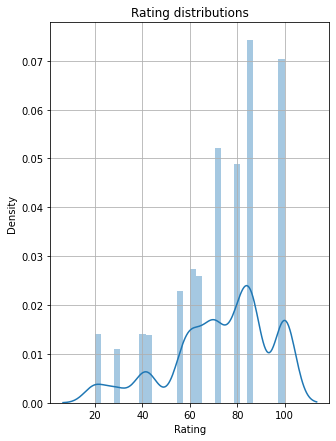

In [7]:
fig, ax = plt.subplots(figsize = (5, 7))
sns.distplot(a = df.Rating, 
             bins = 30, 
             hist = True, 
             ax = ax,
             label = 'Rating')
ax.set_title('Rating distributions')
ax.grid()

Можно заметить, что вообще говоря конечное множество ответов мы видим.

In [8]:

print('We have several levels of rating : {}\nsize of unique values: {}'.format(df.Rating.unique(),
                                                                                 df.Rating.unique().__len__()))

We have several levels of rating : [ 80. 100.  71.  86.  40.  57.  43.  20.  60.  65.  29.]
size of unique values: 11


Частоты каждого (класса) рейтинга.

In [10]:
# -- По сути то, что мы наблюдаем -- #
df.Rating.value_counts()/df.shape[0]

86.0     0.197788
100.0    0.187580
71.0     0.139090
80.0     0.130583
60.0     0.073160
65.0     0.069332
57.0     0.061251
20.0     0.037431
40.0     0.037431
43.0     0.037006
29.0     0.029349
Name: Rating, dtype: float64

Видно, что значения рейтинга принимают конечное множество значений. Всего 11.


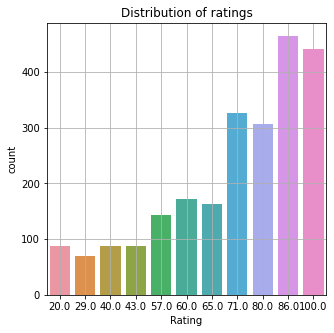

In [11]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.countplot(data = df, x = 'Rating',
              ax = ax,
              label = 'counts')

ax.set_title('Distribution of ratings')
ax.grid(True)

Поучему - то захотелось посмотреть на график длин title-ов.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


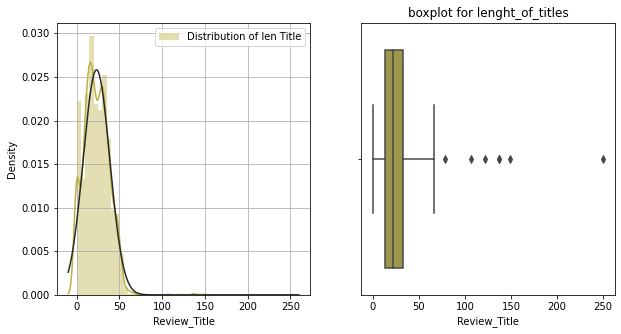

In [13]:
# -- maybe the better use Review_title and text together -- #
from scipy.stats import norm
length_of_titles = df.Review_Title.apply(lambda x: 0 if x is np.nan else len(x))
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.distplot(a = length_of_titles,
             hist = True,
             ax = ax[0],
             label = 'Distribution of len Title',
             fit = norm,   
             color = '#BBB140'          
             )
ax[0].legend()
ax[0].grid()
sns.boxplot(x = length_of_titles, 
            color = '#AAA140', ax= ax[1],
            whis = 2.)

ax[1].set_title('boxplot for lenght_of_titles')

plt.show()

Первая попытка Feature extractions из нашего текста. Тут пока выделил ряд новых признаков по отдельности для title и для text. Признаки по типу длинна текста, колличество больших символов, отношения количества заглавных к количеству всех символов, количество ("!", "?"), пунктуационных символов, количество слов и количество уникальных слов, и их отношения между собой. 

Как окажется ниже не очень хорошо использовать прям все эти признаки в линейных моделей, так как проанализировав их взаимные корреляции видно, что очень много выделенных признаков сильно скоррелированы между собой.


In [14]:
# -- Информация об отсутствии title возможно необходима -- #

# -- len -- #
df['total_length_title'] = df.Review_Title.apply(lambda x: 0 if x is np.nan else len(x))
df['total_length_text'] = df.Review_Text.apply(lambda x: 0 if x is np.nan else len(x))

# -- Number of capitalize -- #

# -- Before work with nan object for Title -- #
#df.Review_Title[df.Review_Title.isna()] = df.Review_Title[df.Review_Title.isna()].apply(lambda title: ' ')

df.Review_Title.apply(lambda x: type(x))
df['num_of_capitals_title'] = df.Review_Title.apply(lambda title: 
                                                    sum(1 for char in title if char.isupper()) if (title is not np.nan) else 0)

df['num_of_capitals_text'] = df.Review_Text.apply(lambda text: sum([1 for char in text if char.isupper()]))


# -- enter some new features -- #
eps = 0.1
df['caps_vs_length'] = df.apply(lambda row: float(row['num_of_capitals_title'])/float(row['total_length_title'] + eps), axis = 1)
# -- Вопрос. и воскл. знаки и препинания -- #
df['num_exclamation_marks_title'] = df.Review_Title.apply(lambda title: title.count('!') if title is not np.nan else 0)
df['num_exclamation_marks_text'] = df.Review_Text.apply(lambda text: text.count('!'))

df['num_quest_marks_title'] = df.Review_Title.apply(lambda title: title.count('?') if title is not np.nan else 0)
df['num_quest_marks_text'] = df.Review_Text.apply(lambda text: text.count('?'))

df['num_punctuation_title'] = df.Review_Title.apply(lambda title: sum(title.count(w) for w in '.,;:') if title is not np.nan else 0)
df['num_punctuation_text'] = df.Review_Text.apply(lambda text: sum(text.count(w) for w in '.,;:'))

# -- num words, num_unique words(locally) -- #
df['num_words_title'] = df.Review_Title.apply(lambda title: len(title.split()) if title is not np.nan else 0)
df['num_words_text'] = df.Review_Text.apply(lambda text: len(text.split()))

df['num_unique_words_title'] = df.Review_Title.apply(lambda title: len(set(w for w in title.split())) if title is not np.nan else 0)
df['num_unique_words_text'] = df.Review_Text.apply(lambda text: len(set(w for w in text.split())))

df['words_vs_unique_title'] = df['num_words_title']/(df['num_unique_words_title'] + eps)
df['words_vs_unique_text'] = df.apply(lambda row: float(row['num_words_text'])/(row['num_unique_words_text'] + eps), axis = 1)

# -- only text -- #
df['num_smilies'] = df.Review_Text.apply(lambda text: sum(text.count(w) for w in (':-)', ':)', ';-)', ';)')))

Посмотрим на скоррелированность данных признаков. 

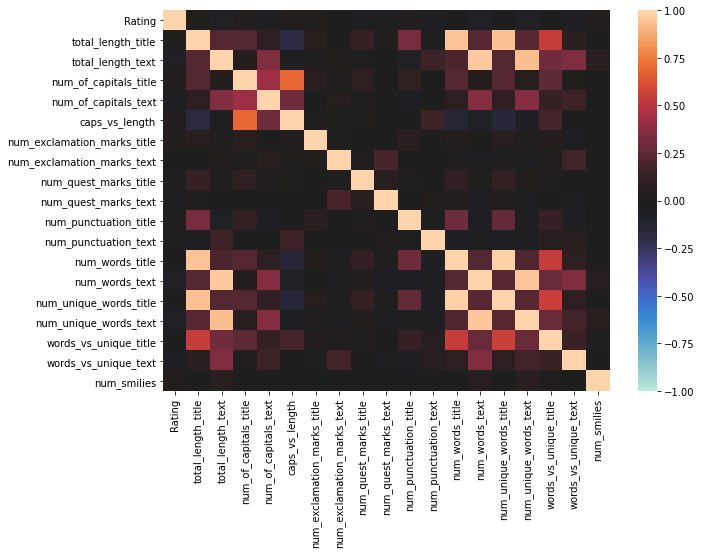

In [15]:
# -- lets see on correleations between new features -- #

fig, ax = plt.subplots(figsize = (10, 7))
correlations_matrix = df.drop(columns = [col for col in df.columns if col.find('Review') != -1]).corr()
ax = sns.heatmap(correlations_matrix, 
                 vmin = -1, 
                 vmax = 1, 
                 center = 0.)
plt.show()


Видно, что считать отдельно вышеописанные признаки как для title части, так и для text неправильно, очень много корреляций. Стоит убрать ряд признаков. Например количество слов и количество уникальных слов - сильно скоррелированные признаки. 

Для простоты взаимодействия с данными было решено объеденить Review_title and Review_Text в один текст. Наверное, это может привести к тому, что некоторые информативные признаки, которые можно выделить только из Review_Title будут утерянны, но так будет проще взаимодействовать с данными (делать нормализацию только для одного текста). 

In [17]:

#lengths_of_names = df_new.Hotel_name.apply(lambda x: len(x.split(' '))).value_counts()
# -- remove Id -- #
if('ID' in set(df_new.columns)):
  df_new = df_new.drop(columns  = ['Id'])

# -- concat together Review_Title and Review_Text -- #
def concatTitleText(title, text):
  if(title is np.nan):
    return text
  else:
    return text + title

df_new['allText'] = df_new.apply(lambda r: concatTitleText(r['Review_Title'], r['Review_Text']), axis = 1)
# -- some check Titles with lower case -- #

#not_nan = df_new.Review_Title.isna().values.astype(bool)
#mask_lower_case = df_new.Review_Title[~not_nan].str[0].apply(lambda x: x.islower())


**Тут мы пишем функцию, которая выделяет из вышеописанных признаков только: суммарную длинну текста (всего вместе с title and text), количество заглавных символов, отношение заглавных символов к всей длинне, Количество ("?", "!", "punctuations"), количество уникальных слов, просто слов, и их отношение и количество смайликов**  

In [18]:
# -- the same preprocessing -- #
def AddFeaturesText(df_not_change, text_column :str):
  """
  get dataframe df_not_change and after we returned a new DataFrame of added Dataset 
  """
  # -- len -- #
  df = df_not_change.copy(deep = True)
  df['total_length_text'] = df[text_column].apply(lambda x: 0 if x is np.nan else len(x))
  # -- Number of capitalize -- #
  
  df['num_of_capitals_text'] = df[text_column].apply(lambda text: sum([1 for char in text if char.isupper()]))
  # -- enter some new features -- #
  
  eps = 0.1
  df['caps_vs_length'] = df.apply(lambda row: float(row['num_of_capitals_text'])/float(row['total_length_text'] + eps), axis = 1)
  # -- Вопрос. и воскл. знаки и препинания -- #

  df['num_exclamation_marks_text'] = df[text_column].apply(lambda text: text.count('!'))
  df['num_quest_marks_text'] = df[text_column].apply(lambda text: text.count('?'))
  df['num_punctuation_text'] = df[text_column].apply(lambda text: sum(text.count(w) for w in '.,;:'))

  # -- num words, num_unique words(locally) -- #
  df['num_words_text'] = df[text_column].apply(lambda text: len(text.split()))
  df['num_unique_words_text'] = df[text_column].apply(lambda text: len(set(w for w in text.split())))
  df['words_vs_unique_text'] = df.apply(lambda row: float(row['num_words_text'])/(row['num_unique_words_text'] + eps), axis = 1)

  # -- only text -- #
  df['num_smilies'] = df[text_column].apply(lambda text: sum(text.count(w) for w in (':-)', ':)', ';-)', ';)')))
  return df

df_new_add = AddFeaturesText(df_new, 'allText')

In [29]:
def removepunctuations(text):
  return text.translate(str.maketrans('', '', punctuations_letters))

def removespecialletterscomplex(text):
  """
  We need not concat in place of special symbols 
  """
  for word in text.split(" "):
    for char in word:
      if not char.isalpha():
        print([word], ' ', [char])

def removePunctSpecial(text):
  """
  remove Punctuations and Other character 
  """
  tokens = word_tokenize(text)
  words = [word for word in tokens if word.isalpha()]
  return " ".join(words)

def removespecialletters(text):
  """
  remove special letters from text 
  we just remove our \n and concatenete words together 
  """
  words = text.split(" ")
  return ' '.join([''.join([char for char in word if char.isalpha()]) for word in words])

def removingstopwords(text):
  """
  remove from text all stopwords of English language
  """
  if(stopwords_ is None):
    print('We need download stopwords of English language')
  words = text.split(" ")
  return " ".join([word for word in words if word not in set(stopwords_)])

def returnFrequentList(df, col_name_text):
  """
  return Counter of all words in dataset frequent vocabulary
  """
  cnt = Counter()
  for row in df.itertuples(index = True, name = 'Pandas'):
    text_current = getattr(row, col_name_text) 
    tokenize = word_tokenize(text_current)
    for word in tokenize:
      cnt[word] += 1
  return cnt 

# -- the better made lemmatization -- # 
# -- it's more complex and stable for noise data -- #
def stemmedtext(text):
  """
  stemming 
  """
  porter = PorterStemmer()
  tokens = word_tokenize(text)
  stemmed = [porter.stem(word) for word in tokens]
  return ' '.join(stemmed)

lemmatizer = WordNetLemmatizer()

def lemmatizationMy(text):
  """
  lematization our text
  """
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def deletefrequentwords(text, topk = topk):
  """
  delete topk frequent words 
  """
  return ' '.join([w for w in str(text).split(' ') if w not in FREQWORDS])

def deleterarewords(text, topk = topk):
  """
  delete downtopk rare words 
  """
  return ' '.join([w for w in str(text).split(' ') if w not in RAREWORDS])


def dropColumns(df, columns: list):
  for col in columns:
    if col in set(df.columns):
      df.drop(columns = [col], inplace = True)
  return df

def preprocessingStandartText(df, 
                              text_column, 
                              stemming = True, 
                              deletewords = False):
  """
  get DataFrame and made simple text Preprocessing (removal punctuations,
  lower case, remove rare words and etc)
  return a new dataset with preprocessed Text representetion
  """
  df_copy = df.copy(deep = True)
  # -- lower -- #
  df_copy[text_column] = df_copy[text_column].str.lower()
  # -- remove punctuations and special cases -- #
  df_copy[text_column] = df_copy[text_column].apply(lambda text: removePunctSpecial(text))
  # -- remove stop words -- #
  df_copy[text_column] = df_copy[text_column].apply(lambda text: removingstopwords(text))
  # -- stemming -- #
  if stemming:
    df_copy[text_column] = df_copy[text_column].apply(lambda text: stemmedtext(text))
  else:
    df_copy[text_column] = df_copy[text_column].apply(lambda text: lemmatizationMy(text))
  # -- lemmatization -- #

  # -- remove rare and very frequent words -- #
  if deletewords:
    # -- delete freq words -- #
    df_copy[text_column] = df_copy[text_column].apply(lambda text: deletefrequentwords(text, topk = topk))
    # -- delete rare words -- #
    df_copy[text_column] = df_copy[text_column].apply(lambda text: deleterarewords(text, topk = downtopk))

  return df_copy



Если посмотреть детальнее, то если проводить preprocessing, которые описан выше, то мы получим достаточно хорошо нормализованный текст, но будет ряд слипшихся слов (2-3 слова), которые алгоритм будет распознавать как одно отдельное слово с определённым смыслом, это связанно с тем, что в первичных данных присутствовало много слипшихся слов, а также некоторых очень длинных слов пор-ка 10-20 с длинной больше 50 символов по типу: "goooooooddseeerrviiicceee" или что-то в таком духе. Всё это вносит некоторый шум в данные. По хорошему нужно как - то в ручную данные конструкции (слипшиеся слова или очень длинные как написано выше заменять на эквивалентные - нормальные слова, но на это уйдет очень много сил, поэтому попробуем сдлеать бэйзлайн для частично нормализованных данных)!!!


**Также я заметил, что не так много отелей во всей выборке, поэтому можно попробовать сгруппировать данные для каждого взятого отеля, с целью выделить некоторые статистические данные, например медианный рейтинг для каждого отеля, но перед этим, необходимо провезти разделение выборки данных на train - test.** Считаю, что это очень сильный признак!!!  

In [31]:
# -- Функция, которая возвращает медианный рейтинг для каждого отдельного отеля -- #

def fillMedianRaiting(row, 
                      hotelStatsRating, 
                      isTest = False):
  try:
    if isTest:
      # -- in dataset -- #
      if(hotelStatsRating.to_dict()['median'].get(str(row['Hotel_name'])) != -1):
        return hotelStatsRating.to_dict()['median'][str(row['Hotel_name'])]
      else:
      # -- not in dataset -- #
        return np.nan
    else:
      return hotelStatsRating.to_dict()['median'][str(row['Hotel_name'])]
  except KeyError:
    print("Error on : {}".format(row['Hotel_name']))
  

In [ ]:
# -- Ниже проводим разбиение выборки данных у которых есть target -- #

Ниже мы проводим разбиение df_train на train and test. И производим выделение как и новых признаков, так и нормализацию тестовых данных, с помощью функциях описанных выше. Также я решил учесть функциональную возможность удалить слишком частые и слишком редкие слова (как окажется это не принесет какой-то пользы при анализе результатов).

In [33]:
from sklearn.model_selection import train_test_split
# -- train model -- #
# -- Linear Regressions -- #

# -- choose SEED -- #
SEED = 42
np.random.seed(SEED)
# -- choose test_size -- #
test_size = 0.3
# -- load all dataset -- #
df_all = pd.read_csv("/content/data/nlp/train.csv", encoding='ISO-8859-1')
# -- shuffle dataset -- #
indeces = df_all.index.tolist()
np.random.shuffle(indeces)
df_all = df_all.loc[indeces, :]
split_index = int(df_all.shape[0] * (1 - test_size))
# -- create train and test data -- #
df_train = df_all.iloc[: split_index, :]
df_test = df_all.iloc[split_index : , :]

# -- check sizes of data -- #
assert(df_train.shape[0] + df_test.shape[0] == df_all.shape[0])

# -- drop Target in test data -- #
y_test = df_test['Rating']
# -- preprocessing and Feature Extraction -- #
# -- concat Title and Text -- #
df_train['allText'] = df_train.apply(lambda r: concatTitleText(r['Review_Title'],
                                                                r['Review_Text']), axis = 1)

df_test['allText'] = df_test.apply(lambda r: concatTitleText(r['Review_Title'],
                                                                r['Review_Text']), axis = 1)

# -- create new features on dirty data text -- #
df_train = AddFeaturesText(df_train, text_column = 'allText')
df_test = AddFeaturesText(df_test, text_column = 'allText')

# -- for deleting most frequent words -- #
topk = 10
FREQWORDS = set([w for w, _ in returnFrequentList(df_train, col_name_text = 'allText').most_common(topk)])

# -- for deleted most rare words -- #
downtopk = 20
RAREWORDS = set([w for w, _ in returnFrequentList(df_train, col_name_text = 'allText').most_common()[-downtopk: ]])

# -- preprocessing our text data from dirty to clean -- #
df_train = preprocessingStandartText(df_train, text_column = 'allText', stemming = False, deletewords=True)
df_test = preprocessingStandartText(df_test, text_column = 'allText', stemming = False, deletewords = True)

# -- create new feature of StatsRaiting -- #
# -- create stats -- #
hotelStatsTrain = df_train.groupby(by = ['Hotel_name'])['Rating'].agg(['median', 
                                                                       'count']).sort_values(by = ['count'],
                                                                                             ascending = False)
# -- fill all Train Examples -- #
df_train['medianRating'] = df_train.apply(lambda r: fillMedianRaiting(r, 
                                                                      hotelStatsTrain, 
                                                                      isTest = False), axis = 1)
# -- fill all Test Examples -- #
df_test['medianRating'] = df_test.apply(lambda r: fillMedianRaiting(r, 
                                                                    hotelStatsTrain, 
                                                                    isTest = True), axis = 1)

print('We have: {} Nan objects in Test We fill it median of all column'.format(df_test.medianRating.isna().sum()))
# -- fill nan oblect just median values from train dataset -- #
df_test.medianRating.fillna(np.median(df_train.medianRating.values), inplace = True)
# -- check na objects in test -- #
assert(df_test.medianRating.isna().sum() == 0)

# -- drop some columns -- #
df_train.columns, df_test.columns 
drop_columns_train = ['Id', 
                'Hotel_name', 
                'Review_Title', 
                'Review_Text', 
                ]

drop_columns_test = ['Id', 
                     'Hotel_name', 
                     'Review_Title', 
                     'Review_Text', 
                     'Rating',
                    ]

df_train = dropColumns(df_train, drop_columns_train)
df_test = dropColumns(df_test, drop_columns_test)
# -- end prepare data -- #

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Error on : Vestin Park
Error on : Stay Easy Serviced Apartments Sholinganalur
Error on : The Chamiers Park
Error on : Oyo Apartments Guduvanchery Srm University
Error on : Oriental Inn
Error on : Shylee Niwas Kodambakkam I
Error on : Lloyds Guest House
Error on : Lloyds Guest House
Error on : Leisure Stays
Error on : Melody
Error on : Oriental Inn
We have: 11 Nan objects in Test We fill it median of all column


Ниже пробывал векторизацию текста как с помощью TfVectorizer, так и с помощью CountVEctorizer. Более хорошие результаты, как и ожидалось, показал TfidfVectorizer. Комментарии ниже нужны просто для того чтобы формировать разные варианты данных, которые объеденяют и выделенные признаки выше, так и просто текстовые данные выделенные с помощью векторизации. 

Лучше всего сработало использовать просто текстовые данные, а не какие-то комбинации данных (проверял и на ансамблях деревьев, чтобы не влиял масштаб численных признаков, так как для линейных моделей очень важно, чтобы признаки численные были нормализованны ).

**Ещё ниже получиться, что если взять данные, котрые были выделены в первую очередь (длинны, символы, количество уникальных\слов), и не ипользовать векторизованный текст, то получаься по точности примерно те же результаты.**

In [35]:
# -- TfVectorizer and CountVectorizer -- #
tfidf = TfidfVectorizer()
countvec = CountVectorizer()

corpus_train = df_train.allText
corpus_test = df_test.allText
corpus_train_vec = tfidf.fit_transform(corpus_train)
corpus_test_vec = tfidf.transform(corpus_test)

corpus_train_count_vec = countvec.fit_transform(corpus_train)
corpus_test_count_vec = countvec.transform(corpus_test)

# -- we shuld concat all data in one dataframe -- #
y_train = df_train['Rating']
stay_columns = ['medianRating']

FLAGFEATIRES = False

"""
    Text and RaitingStats
"""

"""
FLAGFEATIRES = True
std = StandardScaler()

X_feature_train = df_train.loc[:, stay_columns]
X_feature_test = df_test.loc[:, stay_columns]

X_feature_train_arr = std.fit_transform(X_feature_train)
X_feature_test_arr = std.transform(X_feature_test)
"""

"""
    Many things
"""
"""
col_unique = [col for col in df_train.columns if col.find('unique') != -1]
# -- drop cols with unique (Very correlated) -- #

FLAGFEATIRES = True
std = StandardScaler()
X_feature_train = df_train.loc[:, list(set(df_train.columns).difference(['Rating', 
                                                                         'allText', 
                                                                         'Hotel_name']))]

X_feature_test = df_test.loc[:, list(set(df_test.columns).difference(['allText', 
                                                                      'Hotel_name']))]

X_feature_train_arr = std.fit_transform(X_feature_train)
X_feature_test_arr = std.transform(X_feature_test)

"""
# -- stack all data in one sparse matrix -- #

if FLAGFEATIRES:
  #"""
  X_train = hstack((X_feature_train, corpus_train_vec), format = 'csr')
  X_test = hstack((X_feature_test, corpus_test_vec), format = 'csr')
  #"""
else:
  print('Only text features!')
"""
    Only text
"""
# -- Только текст -- #
#"""
X_train = corpus_train_count_vec
X_test = corpus_test_count_vec
#"""
# -- check dimensions -- #
assert(X_test.shape[1] ==  X_train.shape[1])

Only text features!


Посмотрим на численные признаки, которые не относяться к нормализованному тексту. А также на матрицу корреляций:

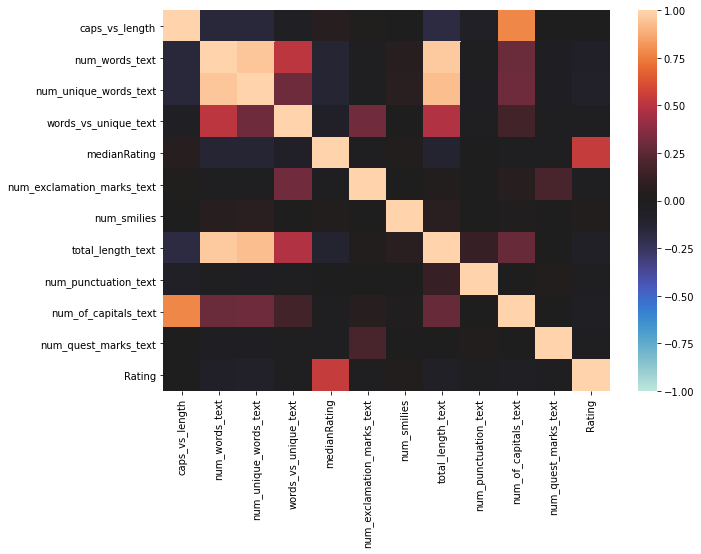

In [37]:
X_feature_train = df_train.loc[:, list(set(df_train.columns).difference(['Rating', 
                                                                         'allText', 
                                                                         'Hotel_name']))]

X_feature_test = df_test.loc[:, list(set(df_test.columns).difference(['allText', 
                                                                      'Hotel_name']))]

df_train_no_text = pd.concat([X_feature_train, y_train], axis = 1)
fig, ax = plt.subplots(figsize = (10, 7))
correlations_matrix = df_train_no_text.corr()
ax = sns.heatmap(correlations_matrix, 
                 vmin = -1, 
                 vmax = 1, 
                 center = 0.)
plt.show()

Пробуем SGD-classifier.

In [38]:
# -- train data -- #
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB 

#std = StandardScaler()
#X_train = std.fit_transform(X_train)
#X_test = std.transform(X_test)

param_grid_sgd = {
    'alpha' : np.logspace(-4, 3, 10),
}
param_grid_logreg = {
    'C' : np.logspace(-4, 3, 10),
}

sgd = SGDClassifier(max_iter = 10000)
svm = SVC()
#logreg = LogisticRegression(solver = 'sag')

kf = KFold(5, shuffle = True)
"""
    Grid for SGD
"""


grid = GridSearchCV(sgd, 
                    param_grid = param_grid_sgd, 
                    cv = kf)

"""
    SVC Grid
"""
"""
grid = GridSearchCV(svm, 
                    param_grid = param_grid_logreg, 
                    cv = kf)
"""
"""
    Grid for Logistic Regr
"""
"""
grid = GridSearchCV(logreg, 
                    param_grid = param_grid_logreg, 
                    cv = kf)
"""
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse: {:.2f}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse: 18.16


**Неплохо, как мне кажеться подходи MultinimialNB - традиционно наивный байес хорошие показывает резульаты в задачах классификации текстов!!!**

In [41]:
# -- Maybe should be CountVectorized -- #

NB_com = MultinomialNB()
param_grid_com_NB = {
    'alpha' : np.linspace(0.001, 1., 100),
}
grid = GridSearchCV(NB_com, 
                    param_grid = param_grid_com_NB, 
                    cv = kf)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse on ComplementNB: {:.2f}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse on ComplementNB: 16.34


Ещё одна вариация Наивного Байеса.

In [42]:
# -- Maybe should be CountVectorized -- #

NB = ComplementNB()
param_grid_NB = {
    'alpha' : np.linspace(0.001, 1., 100),
}
grid = GridSearchCV(NB, 
                    param_grid = param_grid_NB, 
                    cv = kf)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse on ComplementMultinomial: {:.2f}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse on ComplementMultinomial: 18.92


**Добавим новый признак, который опирается на расчёт доли позитивных к всем словам в данных.**

По данным спискам в папке позитивных слов и негативных, рассчитаем признаки отношение позитивных слов по отношению к всем и негативных к всем.

In [43]:
# -- create new data -- #
path_positive = '/content/data/nlp/positive-words.txt'
path_negative = '/content/data/nlp/negative-words.txt'

# -- open and read Positive words -- #
with open(path_positive, 'r', encoding="ISO-8859-1") as f:
  positive_words = [line.rstrip() for line in f]

# -- open and read Negative words -- #
with open(path_negative, 'r', encoding = 'ISO-8859-1') as f:
  negative_words = [line.rstrip() for line in f]
  
  
print('Number of positive words: {}\nNumber of negative words: {}'.format(len(positive_words), 
                                                                              len(negative_words)))
# -- generate new features based on positive and negative words -- #

setPositiveWords = set(positive_words)
setNegativeWords = set(negative_words)

def ratioWordsInText(text, 
                     positive = True):
  """
  calculate positive(d) or negative (d) /all(d)
  """
  if(positive):
    setWords = setPositiveWords
  else:
    setWords = setNegativeWords
  counter = 0
  words = text.split(" ")
  for w in words:
    if w in setWords:
      counter += 1
  return counter / len(words)


df_train['pos2all'] = df_train['allText'].apply(lambda text: ratioWordsInText(text, positive = True))
df_train['neg2all'] = df_train['allText'].apply(lambda text: ratioWordsInText(text, positive = False))

df_test['pos2all'] = df_test['allText'].apply(lambda text: ratioWordsInText(text, positive = True))
df_test['neg2all'] = df_test['allText'].apply(lambda text: ratioWordsInText(text, positive = False))



Number of positive words: 2006
Number of negative words: 4783


Очень уж похоже на то, что целевой признак по сути есть категория --- оценка по условной шкале. Врятли абсолютные значения несут какой-то смысл.

Тут мы просто запускаем Random-Forest на данных, которые не содержат текстовые, которые мы выделили из normalized data. Мы сюда ещё добавили доли позитивных слов и негативных. Как можно видеть качество rmse на уровне того, что мы смогли выделить исключительно из текстовых данных.



In [46]:
# -- maybe better categorize our data -- #

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

# -- only generated features -- #
new_columns_tr = [col for col in df_train.columns if col.find('allText') != 0 and col.find('Rating') != 0]
new_columns_ts = [col for col in df_test.columns if col.find('allText') != 0 and col.find('Rating') != 0]

# -- Не учитывам текстовые данные -- #
df_new_feature_tr = df_train[new_columns_tr]
df_new_feature_ts = df_test[new_columns_ts]

# -- Но у этих признаков слишком много сильно скоррелированных признаков (попробовать ансмбли) -- #            
rf = RandomForestClassifier(n_estimators = 400)
rf.fit(df_new_feature_tr, y_train_le)
# -- Не забыть преобразовать обратно признаки -- #
# -- Точность на сгенерированных данных получилась не хуже, чем на тексте -- #
print("RSME только на выделенных признаках RandomForest: {:.2f}".format(np.sqrt(mean_squared_error(y_test, le.inverse_transform(rf.predict(df_new_feature_ts))))))


RSME только на выделенных признаках RandomForest: 16.74


Попробуем поподбирать гиперпараметры Случайного леса. 

In [50]:
# -- fit hyper parameters -- #
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators' : np.arange(50, 400, 50),
    'max_depth' : np.arange(2,15,3),
    'min_samples_leaf': np.arange(2, 100, 20),
    'max_features' : ['auto', 'sqrt', 'log2'],
}
num_samples = 20
kf = KFold(5, shuffle = True)
rs_tree = RandomizedSearchCV(RandomForestClassifier(), 
                        param_distributions = param_grid,
                        cv = kf, scoring = 'neg_mean_squared_error',
                        n_iter = num_samples)

rs_tree.fit(df_new_feature_tr, y_train_le)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                             

In [51]:
rs_tree.best_params_

{'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 200}

Получившаяся точность обычно перебор по рандомизированной сетке не всегда может попасть в точку, которая минимизирует ошибку предсказания:

In [52]:
y_pred = le.inverse_transform(rs_tree.best_estimator_.predict(df_new_feature_ts))
print("tune RF best rmse: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

tune RF best rmse: 17.07


In [ ]:
# -- we should to generate new data and connect another type of data text data + feature data -- #

### Попробуем WordVec

In [53]:
# -- WordlVec -- #


In [54]:
! pip install gensim 

In [55]:
! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"


--2021-05-12 17:02:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.1MB/s    in 55s     

2021-05-12 17:03:28 (11.7 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [56]:
! wget "https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres/download"


--2021-05-12 17:03:29--  https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres/download
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fneisse%2Fscrapped-lyrics-from-6-genres%3Fresource%3Ddownload [following]
--2021-05-12 17:03:29--  https://www.kaggle.com/account/login?titleType=dataset-downloads&showDatasetDownloadSkip=False&messageId=datasetsWelcome&returnUrl=%2Fneisse%2Fscrapped-lyrics-from-6-genres%3Fresource%3Ddownload
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘download’

download                [ <=>                ]   6.18K  --.-KB/s    in 0.02s   

2021-05-12 17:03:30 (372 KB/s) - ‘download’ saved [6329]



In [57]:
! unzip wiki*


Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [58]:
! head -10 /content/wiki-news-300d-1M.vec

999994 300
, 0.1073 0.0089 0.0006 0.0055 -0.0646 -0.0600 0.0450 -0.0133 -0.0357 0.0430 -0.0356 -0.0032 0.0073 -0.0001 0.0258 -0.0166 0.0075 0.0686 0.0392 0.0753 0.0115 -0.0087 0.0421 0.0265 -0.0601 0.2420 0.0199 -0.0739 -0.0031 -0.0263 -0.0062 0.0168 -0.0357 -0.0249 0.0190 -0.0184 -0.0537 0.1420 0.0600 0.0226 -0.0038 -0.0675 -0.0036 -0.0080 0.0570 0.0208 0.0223 -0.0256 -0.0153 0.0022 -0.0482 0.0131 -0.6016 -0.0088 0.0106 0.0229 0.0336 0.0071 0.0887 0.0237 -0.0290 -0.0405 -0.0125 0.0147 0.0475 0.0647 0.0474 0.0199 0.0408 0.0322 0.0036 0.0350 -0.0723 -0.0305 0.0184 -0.0026 0.0240 -0.0160 -0.0308 0.0434 0.0147 -0.0457 -0.0267 -0.1703 -0.0099 0.0417 0.0235 -0.0260 -0.1519 -0.0116 -0.0306 -0.0413 0.0330 0.0723 0.0365 -0.0001 0.0042 0.0346 0.0277 -0.0305 0.0784 -0.0404 0.0187 -0.0225 -0.0206 -0.0179 -0.2428 0.0669 0.0523 0.0527 0.0149 -0.0708 -0.0987 0.0263 -0.0611 0.0302 0.0216 0.0313 -0.0140 -0.2495 -0.0346 -0.0480 0.0250 0.2130 -0.0330 -0.1553 -0.0292 -0.0346 0.1074 0.0010 -0.0117 -0.0057

In [59]:
! ls -lh

total 2.8G
drwxr-xr-x 4 root root 4.0K May 12 14:49 data
-rw-r--r-- 1 root root 6.2K May 12 17:03 download
drwx------ 5 root root 4.0K May 12 14:49 drive
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data
-rw-r--r-- 1 root root 2.2G Mar 14  2018 wiki-news-300d-1M.vec
-rw-r--r-- 1 root root 651M Jan 18  2019 wiki-news-300d-1M.vec.zip


Мы скаиваем FastText уже готовое представление слов (embedding в размерность пространства 300).

In [60]:
# -- Мы уже скачали представление слов -- #
# -- Скорее всего лучше чем у FastText у нас не получиться -- #

In [61]:
import numpy as np
import tqdm
from tqdm import tqdm

dictionary = {}
times = 0
with open("/content/wiki-news-300d-1M.vec", 'r') as f:
  with tqdm(position = 0, leave = True) as pbar:
    for line in tqdm(f, position = 0, 
                     desc = 'download progress: ', leave = True):
      times += 1
      wplusvec = line.split(" ")
      if wplusvec.__len__() == 301:
        w = wplusvec[0]
        vecd = np.array(wplusvec[1:], dtype = np.float32)
        dictionary[w] = vecd
      if len(dictionary) == 300000:
        break

      pbar.update()

300000it [00:26, 11323.75it/s]


Мы загрузили около 300 тысяч слов из наших данных FastText, мы не грузили весь 1м для скорости.

Ниже я решил поэкспериментировать с выделением "близких" слов данному нам. По косинусной и евклидовой метрике. 

In [62]:
# -- dictionary contain all words -- #
# -- нам нужно построить представление для документов в целом -- #

# -- check top k nearest with word -- #
word = "perfect"
if dictionary.get(word) is not None:
  vec_word = dictionary[word]
else:
  print('not found word: {}'.format(word))

def getkNearest(vec, k, euclid = True):
  """
  get from dictionary k nearest 
  """
  if euclid:
    listvalwordtopk = sorted(list(map(lambda key: [np.linalg.norm(vec - dictionary[key]), key], 
                                                    dictionary.keys())), 
                                                    key = lambda x: x[0])[:k]

    return [w for _, w in listvalwordtopk]

  else:
    fcosine = lambda v1, v2: np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    listvalwordtopk = sorted(list(map(lambda key: [fcosine(vec, dictionary[key]), key], dictionary.keys())), 
                                                  key = lambda x: x[0], 
                                                  reverse = True)[:k]
    return [w for _, w in listvalwordtopk]



topkeucl = getkNearest(vec_word, k = 20, euclid = True)
topkcosine = getkNearest(vec_word, k = 20, euclid = False)


В принципе сематически ближе слова лежать больше в одном направлении, как мне кажется, хотя на и евклидово расстояние что-то разумное дало. Хотя имеются такие слова как Imperfect для Евклидовой нормы, что, как мне кажеться не очень хорошо!

Делаем вывод, что далее будем больше доверять косинусной близости слов. 

Выведем для слова "perfect" близкие слова как по Euclidean Nearest and Cosine Nearest.

In [63]:
[(topkeucl[idx], topkcosine[idx]) for idx in range(min(len(topkeucl), len(topkcosine)))]

[('perfect', 'perfect'),
 ('flawless', 'flawless'),
 ('ideal', 'ideal'),
 ('good', 'near-perfect'),
 ('excellent', 'imperfect'),
 ('wonderful', 'faultless'),
 ('great', 'perfection'),
 ('complete', 'excellent'),
 ('imperfect', 'PERFECT'),
 ('fabulous', 'good'),
 ('perfection', 'wonderful'),
 ('fantastic', 'optimal'),
 ('near-perfect', 'fabulous'),
 ('brilliant', 'complete'),
 ('marvelous', 'Perfect'),
 ('best', 'fantastic'),
 ('full', 'easy'),
 ('better', 'immaculate'),
 ('lovely', 'optimum'),
 ('beautiful', 'superb')]

Теперь с помощью embedding попробуем представлять каждый отдельный текст. Как было показано в материалах к работе, будем строить нечно средне взвешанное всех представлений слов входящих в каждый документ с весами, полученными из tfidf.

In [64]:
# -- just average vector of all words in dictionary -- #
default = sum(dictionary.values())/len(dictionary)
def text2vecsimple(text):
  """
  calculate average of vectors in dictionary
  """
  words = text.split(" ")
  return sum(list(map(lambda w: dictionary.get(w, default), words)))/len(words)

# -- just average of each document in data -- #

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train['allText'])
X_test_tfidf = tfidf.transform(df_test['allText'])

X_train_vec = list(map(lambda text: text2vecsimple(text), df_train['allText']))
X_test_vec = list(map(lambda text: text2vecsimple(text), df_test['allText']))

dim = 300
vocab = np.zeros((len(tfidf.vocabulary_.keys()), dim))

# -- Заполняем все слова из нашего датасета значениями из fasttext -- #
with tqdm(position = 0, leave = True) as pbar:
    for key in tqdm(tfidf.vocabulary_.keys(), 
                    position = 0, 
                    desc = 'bar progress', 
                    leave = True):
      # -- index -- #
      # -- Заполняем значения из нашего словаря с уже фиксированным представлением -- #
      # -- Если в словарике нет, то мы возвращаем значение по умолчанию -- #
      vocab[tfidf.vocabulary_[key]] = dictionary.get(key, default)

# -- result (number of documents, dim) -- #
X_train_weighted = X_train_tfidf.dot(vocab)
X_test_weighted = X_test_tfidf.dot(vocab)


bar progress: 100%|██████████| 3575/3575 [00:00<00:00, 243336.47it/s]
0it [00:00, ?it/s]


**Теперь попробуем некоторые классификаторы на данном признаковом пространстве документов.**

SGD - classifier.

In [66]:
sgd = SGDClassifier(max_iter = 10000)
sgd.fit(X_train_weighted, y_train_le)
y_pred_le = sgd.predict(X_test_weighted)
y_pred = le.inverse_transform(y_pred_le)

print('SGD on World_Vec rmse: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

SGD on World_Vec rmse: 19.64


Logistic regression:

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

pipe = Pipeline([
                 ('std', StandardScaler()),
                 ('logreg', LogisticRegression(class_weight = 'balanced')),
                ])
#"""
X_train_all = np.hstack((X_train_weighted, df_new_feature_tr.values))
X_test_all = np.hstack((X_test_weighted, df_new_feature_ts.values))
#"""

pipe.fit(X_train_all, y_train_le)
y_pred_le = pipe.predict(X_test_all)
y_pred = le.inverse_transform(y_pred_le)

print('Logistic Regression on World_Vec rmse: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Logistic Regression on World_Vec rmse: 18.69


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Случайный лес:

In [71]:
rf = RandomForestClassifier(n_estimators = 400)
# -- together another features -- #
X_train_all = np.hstack((X_train_weighted, df_new_feature_tr.values))
X_test_all = np.hstack((X_test_weighted, df_new_feature_ts.values))

rf.fit(X_train_all, y_train_le)

y_pred_le = rf.predict(X_test_all)
y_pred = le.inverse_transform(y_pred_le)

print('RandomForest on World_Vec rmse: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RandomForest on World_Vec rmse: 18.71


Метод опорных векторов:

In [72]:
svm = SVC()
svm.fit(X_train_weighted, y_train_le)

y_pred_le = svm.predict(X_test_weighted)
y_pred = le.inverse_transform(y_pred_le)

print('SVM on World_Vec rmse: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

SVM on World_Vec rmse: 22.84


Как мы видим точность хуже чем то, что мы сделали простой нормализацией текста с Tfidf и просто выделением некоторых информативных признаков!

In [73]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 67.3MB 86kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


На крайний случай попробуем catboost

In [74]:
from catboost import Pool, CatBoostClassifier

# initialize pool
train_pool = Pool(
                X_train_all,
                y_train_le,
                  )

test_pool = Pool(
                X_test_all,
                y_test_le,
                  )

model = CatBoostClassifier(iterations = 500, 
                          depth = 4, 
                          learning_rate= 0.01, 
                          loss_function='MultiClass', 
                          verbose = 1,
                           )
#train the model
model.fit(train_pool, verbose = 0)
# make the prediction using the resulting model
preds_le = model.predict(test_pool)
preds = le.inverse_transform(preds_le)
print('root MSE without fit hyperparameters for catboost on test: {}'.format(np.sqrt(mean_squared_error(preds, 
                                                                    y_test))))

root MSE without fit hyperparameters for catboost on test: 19.497838915623532


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Попытки комбинировать признаки, которые удалось выделить вручную с чисто текстовыми признаками, которые получались в результате нормализации текста оказались не особо продуктивными. Возможно стоит настроить отельно два классификатора и построить среднии ответы на предсказаниях, грубо говоря сделать что-то вроде blending. Но это уже другая история!))
